In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import specsim.simulator

In [3]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']

/Users/belaabolfathi/anaconda3/envs/galsim/lib/python3.6/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [4]:
eboss_wlen = np.load('b_loglam.npy')

### Test cases for resampled functions (sanity check)

In [5]:
def resample_binned(edges_out, edges_in, hist_in, axis=-1, zero_pad=True):
    """Flux conserving linear resampler of binned data.
    Parameters
    ----------
    edges_out : array
        1D array of M >= 2 output bin edges, in increasing order.
    edges_in : array
        1D array of N >= 2 input bin edges, in increasing order.
    hist_in : array
        Array with N-1 input bin values indexed by the specified axis.
    axis : int
        Axis of hist_in used to index input histogram values.
    zero_pad : bool
        When True, allow the output edges to extend beyond the input
        edges and assume that the input histogram is zero outside of
        its extent.  When False, raises a ValueError if extrapolation
        would be required.
    Returns
    -------
    array
        1D array of M-1 resampled bin values.
    """
    # Check input 1D arrays.
    edges_out = np.asarray(edges_out)
    edges_in = np.asarray(edges_in)
    if edges_out.ndim != 1:
        raise ValueError('Expected 1D edges_out.')
    if edges_in.ndim != 1:
        raise ValueError('Expected 1D edges_in.')
    if len(edges_out) < 2:
        raise ValueError('Need at least one output bin.')
    if len(edges_in) < 2:
        raise ValueError('Need at least one input bin.')
    binsize_out = np.diff(edges_out)
    if np.any(binsize_out <= 0):
        raise ValueError('Expecting increasing edges_out.')
    binsize_in = np.diff(edges_in)
    if np.any(binsize_in <= 0):
        raise ValueError('Expecting increasing edges_in.')
    if not zero_pad and ((edges_out[0] < edges_in[0]) or
                         (edges_out[-1] > edges_in[-1])):
        raise ValueError(
            'Ouput bins extend beyond input bins but zero_pad is False.')
    if (edges_out[0] >= edges_in[-1]) or (edges_out[-1] <= edges_in[0]):
        raise ValueError('Input and output bins do not overlap.')
    # Check input histogram(s) and put index in axis 0. Note that we
    # use moveaxis instead of rollaxis since it is easier to invert.
    hist_in = np.asarray(hist_in)
    hist_in_rolled = np.moveaxis(hist_in, axis, 0)
    if len(hist_in_rolled) != len(edges_in) - 1:
        raise ValueError(
            'Unexpected length of hist_in along axis {}.'.format(axis))
    # Align output edges to input edges.
    idx = np.searchsorted(edges_in, edges_out)
    # Loop over output bins.
    nin = len(edges_in) - 1
    nout = len(edges_out) - 1
    hist_out_rolled_shape = (nout,) + hist_in_rolled.shape[1:]
    hist_out_rolled = np.zeros(hist_out_rolled_shape)
    hi = idx[0]
    for i in range(nout):
        lo = hi
        hi = idx[i + 1]
        if (lo > nin) or (hi == 0):
            # This bin does not overlap the input.
            continue
        if lo == hi:
            # Output bin is fully embedded within an input bin:
            # give it a linear share.
            hist_out_rolled[i] = (
                binsize_out[i] / binsize_in[lo - 1] * hist_in_rolled[lo - 1])
            continue
        # Calculate fraction of first input bin overlapping this output bin.
        if lo > 0:
            hist_out_rolled[i] += (
                hist_in_rolled[lo - 1] / binsize_in[lo - 1] * (
                    edges_in[lo] - edges_out[i]))
        # Calculate fraction of last input bin overlaping this output bin.
        if hi <= nin:
            hist_out_rolled[i] += (
                hist_in_rolled[hi - 1] / binsize_in[hi - 1] * (
                    edges_out[i + 1] - edges_in[hi - 1]))
        # Add input bins fully contained within this output bin.
        if hi > lo + 1:
            hist_out_rolled[i] += np.sum(hist_in_rolled[lo:hi - 1], axis=0)
    # Return our unrolled output histogram.
    return np.moveaxis(hist_out_rolled, axis, 0)

In [34]:
dat = np.random.normal(loc=0, scale=1.0, size=100)
edges_in = np.arange(-3,4,1)
hist_in, _ = np.histogram(dat, edges_in)
edges_out = np.arange(-3,4,2)

In [35]:
hist_out = resample_binned(edges_out, edges_in, hist_in)

In [40]:
mdpt_in = 0.5 * (edges_in[1:] + edges_in[:-1])

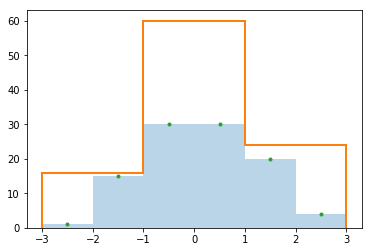

In [46]:
plt.hist(dat, bins=edges_in, alpha=0.3)
plt.hist(dat, bins=edges_out, histtype='step', lw=2)
plt.plot(mdpt_in, hist_in, '.')
plt.show()

Good - works as we would expect. Now I want to write my own downsampling function, do it the long way first so that I understand each step of what is going on. After this I will verify that I get the same result using `skysim.utils.resample_density()` then `skysim.utils.resample_binned()`. 

The first thing we need to do is to convert from flux density to counts. We do this by multiplying the flux by the bin width. Create `b_edges` so that the midpoint of each bin is centered on the values `b_wlen`.

Note: some of the `b_flux` and `r_flux` values are nan's ... need to look into this (maybe has to do with how throughput is calculated for wavelength values that fall outside of the wavelength grid for each camera?)

In [83]:
## Bin width
b_diff = np.diff(b_wlen)
print(np.all(b_diff[0] == b_diff))
b_diff = b_diff[0]

True


In [133]:
## Define nominal bin edges
b_edges = b_wlen - (0.5 * b_diff)
b_edges = np.append(b_edges, b_edges[-1] + b_diff)
b_edges = np.log10(b_edges)

In [96]:
b_counts = b_flux * b_diff
## b_counts, b_edges is our simulation histogram

In [119]:
## Define eBOSS bin edges
eboss_wlen = np.load('b_loglam.npy')
eboss_diff = np.diff(eboss_wlen)
eboss_diff_app = np.append(eboss_diff, eboss_diff[-1])
eboss_edges = eboss_wlen - (0.5 * eboss_diff_app)
eboss_edges = np.append(eboss_edges, eboss_edges[-1] + eboss_diff_app[-1])

### First pass: do edge cases next

In [265]:
idx_in_eboss = np.searchsorted(eboss_edges, b_edges)

In [283]:
idx_in_eboss, len(idx_in_eboss), len(eboss_edges)

(array([ 196,  197,  198, ..., 4040, 4041, 4041]), 8253, 4129)

In [315]:
output_hist = np.zeros_like(eboss_edges)
j = 0 ## index keeping track of where we leave off in b_edges
## Loop over idx_in_eboss - this determines bin interval in eboss_edges
for i, idx in enumerate(idx_in_eboss):
    left = eboss_edges[idx-1]
    right = eboss_edges[idx]
    ## Find elements in b_edges that lie between left and right
    within = []
    print(j)
    if j < len(b_edges):
        while b_edges[j] < right:
            within.append(j)
            j += 1
        print(within)
        output_hist[idx-1] = np.sum(b_counts[within])

0
[0]
1
[1]
2
[2, 3]
4
[]
4
[4, 5]
6
[]
6
[6, 7]
8
[]
8
[8, 9]
10
[]
10
[10]
11
[11, 12]
13
[]
13
[13, 14]
15
[]
15
[15, 16]
17
[]
17
[17]
18
[18, 19]
20
[]
20
[20, 21]
22
[]
22
[22, 23]
24
[]
24
[24, 25]
26
[]
26
[26]
27
[27, 28]
29
[]
29
[29, 30]
31
[]
31
[31, 32]
33
[]
33
[33]
34
[34, 35]
36
[]
36
[36, 37]
38
[]
38
[38, 39]
40
[]
40
[40, 41]
42
[]
42
[42]
43
[43, 44]
45
[]
45
[45, 46]
47
[]
47
[47, 48]
49
[]
49
[49, 50]
51
[]
51
[51]
52
[52, 53]
54
[]
54
[54, 55]
56
[]
56
[56, 57]
58
[]
58
[58, 59]
60
[]
60
[60]
61
[61, 62]
63
[]
63
[63, 64]
65
[]
65
[65, 66]
67
[]
67
[67]
68
[68, 69]
70
[]
70
[70, 71]
72
[]
72
[72, 73]
74
[]
74
[74, 75]
76
[]
76
[76]
77
[77, 78]
79
[]
79
[79, 80]
81
[]
81
[81, 82]
83
[]
83
[83, 84]
85
[]
85
[85]
86
[86, 87]
88
[]
88
[88, 89]
90
[]
90
[90, 91]
92
[]
92
[92, 93]
94
[]
94
[94]
95
[95, 96]
97
[]
97
[97, 98]
99
[]
99
[99, 100]
101
[]
101
[101, 102]
103
[]
103
[103]
104
[104, 105]
106
[]
106
[106, 107]
108
[]
108
[108, 109]
110
[]
110
[110, 111]
112
[]
1

IndexError: index 8253 is out of bounds for axis 0 with size 8253

In [307]:
len(idx_in_eboss), len(b_edges)

(8253, 8253)

In [277]:
output_hist = np.zeros_like(eboss_edges)
j = 0
for i range(len(eboss_edges)):
    within = []
    left = eboss_edges[idx-1]
    right = eboss_edges[idx]
    while np.logical_and(b_edges[j] < right, j < len(b_edges) - 1):
        within.append(j)
        j += 1
    output_hist[i] = np.sum(b_counts[within])

IndexError: index 4129 is out of bounds for axis 0 with size 4129

In [278]:
len(eboss_edges), len(idx_in_eboss)

(4129, 8253)

In [240]:
b_idx = np.argmin(b_edges - eboss_edges[0])
output_hist = np.zeros_like(eboss_edges)
for i in range(len(eboss_edges)):
    within = []
    print(i)
    while b_edges[b_idx] < eboss_edges[i]:
        within.append(b_idx)
        b_idx += 1
    output_hist[i] = np.sum(b_counts[within])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: index 8253 is out of bounds for axis 0 with size 8253

In [239]:
len(b_edges), len(eboss_edges)

(8253, 4129)

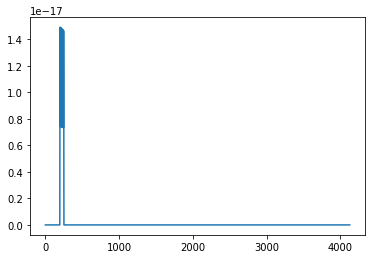

In [236]:
plt.plot(output_hist)
plt.show()

In [217]:
np.argwhere(b_edges > eboss_edges[0])

array([[   0],
       [   1],
       [   2],
       ...,
       [8250],
       [8251],
       [8252]])

In [215]:
np.argmin(np.abs(b_edges - eboss_edges[1]))

0

In [211]:
eboss_edges[196], b_edges[0]

(3.4787014017753775, 3.4786891195795167)

In [ ]:
## Loop over output grid
## Before the first iteration, calculate fraction of left-most bin in the
## first output grid bin (right fraction)
## right_frac = 

if b_edges[0] > eboss_edges[1]:
    input_idx_start = np.argmin(np.abs())

input_idx_start = np.argmin(b_edges - eboss_edges[0])

for i in range(len(eboss_edges)):
    left_bin = eboss_edges[i]
    right_bin = eboss_edges[i+1]
    
    